## About the project
The purpose of this analysis is to explore product performance, customer segmentation, and marketing effectiveness for TheLook eCommerce. The goal is to identify key areas where inventory management and customer acquisition efforts can be optimized to improve profitability, especially in the women’s clothing category, which represents 40% of overall sales.


## Project setup and data preparation
In this section, I set up the project by importing the necessary libraries, loading and cleaning the data, and defining reusable functions. I also established a consistent visual style for the visualisations leveraging `Plotly` with custom fonts, colors, and templates for interactive charts.

### Setup and Imports
I imported necessary libraries to handle data manipulation, visualization, and time series forecasting.



In [1030]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from prophet import Prophet
from IPython.display import display
from pandas.tseries.offsets import DateOffset

### File Paths
I set the file paths for the datasets used throughout the analysis. The outdir will be used to save new data and results.


In [1031]:
file_paths = {
    'order_items': '../data/order_items.csv',
    'orders': '../data/orders.csv',
    'products':'../data/products.csv',
    'users': '../data/users.csv',
    'product_performance': '../outdir/product_performance.csv'
}

outdir = '../outdir'

### Functions for Data Cleaning
To streamline data cleaning, I created reusable functions to load data, standardize column names, handle date conversion, and check for missing values.

In [1032]:
def load_data(file_path):
    return pd.read_csv(file_path)

def standardize_column_names(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return df

def convert_to_datetime(df, date_columns):
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def missing_values_summary(df):
    missing_values = df.isnull().sum()
    return missing_values[missing_values > 0]


### Pricing Strategy
I implemented a dynamic pricing function that adjusts product prices based on category and seasonality to reflect real-world conditions. This will be applied later in the analysis.

In [1033]:
def apply_realistic_pricing(row):
    # Define price thresholds
    LOW_PRICE_THRESHOLD = 100
    MID_PRICE_THRESHOLD = 150
    
    # No discount for products below the low price threshold
    if row['retail_price'] < LOW_PRICE_THRESHOLD:
        return row['retail_price']
    
    # Randomly apply a small discount for products between the low and mid price threshold
    elif LOW_PRICE_THRESHOLD <= row['retail_price'] < MID_PRICE_THRESHOLD:
        if np.random.random() > 0.5:  # 50% chance to apply a discount
            return row['retail_price'] * np.random.uniform(0.95, 1.00)
        else:
            return row['retail_price']
    
    # For products above the mid price threshold, randomly apply either a discount or markup
    random_choice = np.random.random()

    # 50% chance for either a markup or discount
    if random_choice > 0.5:
        return row['retail_price'] * np.random.uniform(1.10, 1.20)  # Apply markup
    else:
        return row['retail_price'] * np.random.uniform(0.80, 0.95)  # Apply discount

### Visual Setup
To ensure all visualizations are consistent and aligned with the company’s branding, I defined custom color palettes, font settings, and a Plotly template for all charts.

In [1034]:
###### Font and Color Settings
######  I set the font family to 'Lato' and created color schemes for different types of visual elements like campaigns and country highlights.

# Font for visualizations
font_family = 'Lato'

# Primary and secondary color palette
custom_colors = [
    "#607D77", "#466661", "#ECF2F0", "#2D494C"  # Main brand colors
]

# Additional color palettes for various categories
custom_colors2 = [
    "#E2F0E6", "#B7E0B1", "#8CCB8C", "#4EA96B", "#0B903F", "#007A33"
]

custom_colors3 = [
    "#ECF2F0", "#A3C1C2", "#89A9AA", "#6A8B8C", "#4B6B6E", "#3A585B", "#2D494C", "#1F3A3B"
]

alert_colors = [
    "#FFCCCC", "#FF9999", "#FF6666", "#FF3333", "#CC0000", "#990000"
]

country_highlight_colors = [
    "#2D494C", "#4B3D3D", "#3C5A3F", "#5D4C8A", "#2F2A2A", "#6B3F3F", "#1F4E79", "#4B2C2C", "#1A1A1A", "#3D5B7C"
]

multiple_categories = [
    '#9D84BF', '#C29E8C', '#F2E74B', '#B2E4D4', '#6B3F3F',
    '#B2C495', '#D0E1A5', '#DEB887', '#3CB371', '#FF6F61',
    '#8A7ED9', '#F2B441', '#4946A6', '#1F4E79', '#282C40'
]

colors_campaign = [
    '#4CAF50', '#1E88E5', '#00ACC1', '#FF7043', '#E53935',
    '#8E24AA', '#F06292', '#BDBDBD', '#8BC34A', '#00BCD4'
]


In [1035]:
###### Custom Plotly Template
######  I mapped specific columns to more readable labels for easier interpretation in visualizations.

# Define custom template for consistent chart styling
custom_template = go.layout.Template(
    layout=go.Layout(
        font=dict(
            family=font_family,
            size=14,
            color='#2D494C'
        ),
        title=dict(
            text='<b>Your Chart Title</b>',
            font=dict(size=24),
            x=0.5
        ),
        legend=dict(
            title=dict(
                text='<b>Legend Title</b>',
                font=dict(size=16, color='#2D494C')
            ),
            font=dict(size=12)
        ),
        xaxis=dict(
            title=dict(text='<b>X Axis Title</b>', font=dict(size=16)),
            tickfont=dict(size=12),
            showgrid=False
        ),
        yaxis=dict(
            title=dict(text='<b>Y Axis Title</b>', font=dict(size=16)),
            tickfont=dict(size=12),
            showgrid=False
        ),
        hoverlabel=dict(
            bgcolor='#E5F2F2',
            bordercolor='#2D494C',
            font=dict(size=14, color='#2D494C')
        ),
        paper_bgcolor='#FDFDFD',
        plot_bgcolor='#FDFDFD'
    )
)

# Set this template as default for all visualizations
pio.templates['custom_template'] = custom_template
pio.templates.default = 'custom_template'

## Data loading, cleaning, and preparation

In this section, I loaded the necessary datasets, cleaned them, handled missing values, and merged them into a final, clean dataset ready for analysis. Here's how I did it and the results from each step.

### Loading datasets 
The datasets were loaded successfully, with order details, product information, and customer demographics. 

**Key dataframes:**

`Order Items:` Detailed records of purchased products. <br>
`Orders:` High-level order summary data.<br>
`Products:` Product catalog with pricing and category details.<br>
`Users:` Demographic information of customers.

In [1036]:
# Load datasets
order_items = load_data(file_paths['order_items'])
orders = load_data(file_paths['orders'])
products = load_data(file_paths['products'])
users = load_data(file_paths['users'])

# Display the first few rows of each dataset
print("Order Items")
display(order_items.head())

print("Orders")
display(orders.head())

print("Products")
display(products.head())

print("Users")
display(users.head())

Order Items


,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaN,NaN,NaN,0.02
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaN,0.02
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaN,0.02
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaN,NaN,0.02
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaN,NaN,0.02


Orders


,order_id,user_id,status,gender,created_at,returned_at,shipped_at,delivered_at,num_of_item
0,8,5,Cancelled,F,2022-10-20 10:03:00+00:00,NaN,NaN,NaN,3
1,60,44,Cancelled,F,2023-01-20 02:12:00+00:00,NaN,NaN,NaN,1
2,64,46,Cancelled,F,2021-12-06 09:11:00+00:00,NaN,NaN,NaN,1
3,89,65,Cancelled,F,2020-08-13 09:58:00+00:00,NaN,NaN,NaN,1
4,102,76,Cancelled,F,2023-01-17 08:17:00+00:00,NaN,NaN,NaN,2


Products


,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,13842,2.51875,Accessories,Low Profile Dyed Cotton Twill Cap - Navy W39S55D,MG,6.25,Women,EBD58B8A3F1D72F4206201DA62FB1204,1
1,13928,2.33835,Accessories,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,MG,5.95,Women,2EAC42424D12436BDD6A5B8A88480CC3,1
2,14115,4.87956,Accessories,Enzyme Regular Solid Army Caps-Black W35S45D,MG,10.99,Women,EE364229B2791D1EF9355708EFF0BA34,1
3,14157,4.64877,Accessories,Enzyme Regular Solid Army Caps-Olive W35S45D (...,MG,10.99,Women,00BD13095D06C20B11A2993CA419D16B,1
4,14273,6.50793,Accessories,Washed Canvas Ivy Cap - Black W11S64C,MG,15.99,Women,F531DC20FDE20B7ADF3A73F52B71D0AF,1


Users


,id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at
0,457,Timothy,Bush,timothybush@example.net,65,M,Acre,87620 Johnson Hills,69917-400,Rio Branco,Brasil,-9.945568,-67.83561,Search,2022-07-19 13:51:00+00:00
1,6578,Elizabeth,Martinez,elizabethmartinez@example.com,34,F,Acre,1705 Nielsen Land,69917-400,Rio Branco,Brasil,-9.945568,-67.83561,Search,2023-11-08 18:49:00+00:00
2,36280,Christopher,Mendoza,christophermendoza@example.net,13,M,Acre,125 Turner Isle Apt. 264,69917-400,Rio Branco,Brasil,-9.945568,-67.83561,Email,2019-08-24 06:10:00+00:00
3,60193,Jimmy,Conner,jimmyconner@example.com,64,M,Acre,0966 Jose Branch Apt. 008,69917-400,Rio Branco,Brasil,-9.945568,-67.83561,Search,2020-02-15 11:26:00+00:00
4,64231,Natasha,Wilson,natashawilson@example.net,25,F,Acre,20798 Phillip Trail Apt. 392,69917-400,Rio Branco,Brasil,-9.945568,-67.83561,Search,2020-03-13 06:45:00+00:00


### Standardizing the dataframes
I ensured that we had a consistent formatting (lowercase and underscores) then converted all relevant columns to the appropriate data types.

In [1037]:
# Standardize column names
order_items = standardize_column_names(order_items)
orders = standardize_column_names(orders)
products = standardize_column_names(products)
users = standardize_column_names(users)

# Convert columns to proper data types
order_items = convert_to_datetime(order_items, ['created_at', 'shipped_at', 'delivered_at', 'returned_at'])
orders = convert_to_datetime(orders, ['created_at', 'shipped_at', 'delivered_at', 'returned_at'])
users = convert_to_datetime(users, ['created_at'])
order_items = convert_to_numeric(order_items, ['sale_price'])
products = convert_to_numeric(products, ['retail_price'])


### Handling missing values

I identified missing values across the datasets. `shipped_at` and `delivered_at` were missing in some orders, and a few products were missing pricing information. <br>This helped us understand where further cleaning was required.

In [1038]:
# Summarize missing values
missing_order_items = missing_values_summary(order_items)
missing_orders = missing_values_summary(orders)
missing_products = missing_values_summary(products)
missing_users = missing_values_summary(users)

# Display missing values
print("Missing Values in Order Items")
display(missing_order_items)

print("Missing Values in Orders")
display(missing_orders)

print("Missing Values in Products")
display(missing_products)

print("Missing Values in Users")
display(missing_users)


Missing Values in Order Items


created_at        4405
shipped_at       66349
delivered_at    119473
returned_at     163975
dtype: int64

Missing Values in Orders


created_at        3063
returned_at     113001
shipped_at       45772
delivered_at     82412
dtype: int64

Missing Values in Products


Series([], dtype: int64)

Missing Values in Users


created_at    2393
dtype: int64

### Flagging missing data
Flags were created for orders missing shipment data and products missing prices. This allows us to filter out incomplete records in the next steps and focus on high-quality data.

**Shipping Flag**: Flags any order missing shipment or delivery information. <br>
**Price Flag**: Flags any product missing `retail_price`

In [1039]:
# Flag missing shipped_at or delivered_at for review
order_items['shipping_flag'] = order_items['shipped_at'].isnull() | order_items['delivered_at'].isnull()
orders['shipping_flag'] = orders['shipped_at'].isnull() | orders['delivered_at'].isnull()

# Flag missing retail_price
products['price_flag'] = products['retail_price'].isnull()

In [1040]:
# Checking the datatypes integrity
print("Data types in Order Items")
display(order_items.dtypes)

print("Data types in Orders")
display(orders.dtypes)

print("Data types in Products")
display(products.dtypes)

print("Data types in Users")
display(users.dtypes)


Data types in Order Items


id                                 int64
order_id                           int64
user_id                            int64
product_id                         int64
inventory_item_id                  int64
status                            object
created_at           datetime64[ns, UTC]
shipped_at           datetime64[ns, UTC]
delivered_at         datetime64[ns, UTC]
returned_at          datetime64[ns, UTC]
sale_price                       float64
shipping_flag                       bool
dtype: object

Data types in Orders


order_id                       int64
user_id                        int64
status                        object
gender                        object
created_at       datetime64[ns, UTC]
returned_at      datetime64[ns, UTC]
shipped_at       datetime64[ns, UTC]
delivered_at     datetime64[ns, UTC]
num_of_item                    int64
shipping_flag                   bool
dtype: object

Data types in Products


id                          int64
cost                      float64
category                   object
name                       object
brand                      object
retail_price              float64
department                 object
sku                        object
distribution_center_id      int64
price_flag                   bool
dtype: object

Data types in Users


id                              int64
first_name                     object
last_name                      object
email                          object
age                             int64
gender                         object
state                          object
street_address                 object
postal_code                    object
city                           object
country                        object
latitude                      float64
longitude                     float64
traffic_source                 object
created_at        datetime64[ns, UTC]
dtype: object

### Filtering and merging data

Filtered out incomplete records (orders with missing shipment dates and products with missing prices) and merged the cleaned datasets. The final merged dataset contains order, product, and customer information, ready for analysis.

In [1041]:
# Filter out incomplete orders and products
cleaned_order_items = order_items[order_items['status'] == 'Complete']
cleaned_order_items = cleaned_order_items[cleaned_order_items['shipping_flag'] == False]
cleaned_products = products[products['price_flag'] == False]

# Merge the cleaned datasets
product_performance = pd.merge(cleaned_order_items, cleaned_products, how='inner', left_on='product_id', right_on='id')
product_performance = pd.merge(product_performance, users, how='inner', left_on='user_id', right_on='id')

# Display the merged dataset
display(product_performance.head())


,id_x,order_id,user_id,product_id,inventory_item_id,status,created_at_x,shipped_at,delivered_at,returned_at,...,gender,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at_y
0,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,...,F,Jiangsu,5374 Courtney Parkway,215007,Yulin,China,31.278607,120.642997,Organic,2022-07-15 03:59:00+00:00
1,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,...,F,Texas,7187 Michael Forge Apt. 777,75604,Longview,United States,32.512434,-94.825486,Organic,2019-06-22 13:23:00+00:00
2,67253,46269,37023,14159,181497,Complete,2021-10-31 01:26:46+00:00,2021-11-01 17:47:00+00:00,2021-11-02 13:29:00+00:00,NaT,...,F,Paraná,129 Michele Ranch Suite 046,81020-490,Curitiba,Brasil,-25.503070,-49.331363,Search,2019-08-10 04:05:00+00:00
3,116116,80002,63821,14159,313368,Complete,2022-04-01 13:25:52+00:00,2022-03-31 05:13:00+00:00,2022-04-02 22:18:00+00:00,NaT,...,F,Distrito Federal,208 Powell Estate,72110-600,TBA,Brasil,-15.819792,-48.048672,Organic,2022-03-21 16:49:00+00:00
4,54884,37750,30232,28700,148082,Complete,2023-02-27 02:31:30+00:00,2023-03-01 14:39:00+00:00,2023-03-03 16:51:00+00:00,NaT,...,M,Sergipe,378 Christine Forks,49200-000,Estância,Brasil,-11.249017,-37.398120,Search,2019-10-10 03:17:00+00:00


In [1042]:
# Drop unnecessary columns
columns_to_drop = ['street_address', 'postal_code', 'state', 'sku', 'distribution_center_id', 'first_name', 'last_name', 'email', 'name', 'department', 'returned_at']
product_performance = product_performance.drop(columns=columns_to_drop)

# Save the cleaned dataset
product_performance.to_csv(os.path.join(outdir, 'product_performance.csv'), index=False)

# Display the final dataset information
product_performance.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44502 entries, 0 to 44501
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   id_x               44502 non-null  int64              
 1   order_id           44502 non-null  int64              
 2   user_id            44502 non-null  int64              
 3   product_id         44502 non-null  int64              
 4   inventory_item_id  44502 non-null  int64              
 5   status             44502 non-null  object             
 6   created_at_x       44502 non-null  datetime64[ns, UTC]
 7   shipped_at         44502 non-null  datetime64[ns, UTC]
 8   delivered_at       44502 non-null  datetime64[ns, UTC]
 9   sale_price         44502 non-null  float64            
 10  shipping_flag      44502 non-null  bool               
 11  id_y               44502 non-null  int64              
 12  cost               44502 non-null  float64    

---------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Revenue, Profitability, and Performance Analysis

The objective of this analysis is to understand the revenue, profitability, and overall performance of product categories, customer segments, and traffic sources.<br>
This involves calculating key metrics such as revenue, profitability, average order value (AOV), and conversion rate over time.

### Analyzing Revenue and Profitability by Year and Quarter

**What I did:**
I calculated the total *revenue* and *profitability* by year and quarter to get an overview of how the company’s financials evolved over time.

**What I got:**
Revenue increased steadily over time, with some quarters in 2021 and 2023 showing significant jumps. Initially, profitability was either zero or negative, but after adjusting for more realistic pricing, profitability began to improve. 

In [1043]:
# 1. Aggregate revenue by year and quarter
product_performance['year'] = product_performance['created_at_x'].dt.year
product_performance['quarter'] = product_performance['created_at_x'].dt.quarter
product_performance['revenue'] = product_performance['sale_price']

# Summing up the revenue by year and quarter
revenue_by_time = product_performance.groupby(['year', 'quarter'])['revenue'].sum().reset_index()

display(revenue_by_time)

# 2. Calculate profitability
product_performance['profitability'] = product_performance['sale_price'] - product_performance['retail_price']

# Aggregate revenue and profitability by year and quarter
kpm_1 = product_performance.groupby(['year', 'quarter']).agg({
    'revenue': 'sum',
    'profitability': 'sum'
}).reset_index()

display(kpm_1)


,year,quarter,revenue
0,2019,1,2148.230006
1,2019,2,9127.729986
2,2019,3,17527.149997
3,2019,4,24412.450044
4,2020,1,35027.580022
5,2020,2,46035.060017
6,2020,3,50046.790070
7,2020,4,56647.580041
8,2021,1,77389.700085
9,2021,2,83640.650142


,year,quarter,revenue,profitability
0,2019,1,2148.230006,0.0
1,2019,2,9127.729986,0.0
2,2019,3,17527.149997,0.0
3,2019,4,24412.450044,0.0
4,2020,1,35027.580022,0.0
5,2020,2,46035.060017,0.0
6,2020,3,50046.790070,0.0
7,2020,4,56647.580041,0.0
8,2021,1,77389.700085,0.0
9,2021,2,83640.650142,0.0


### Data manipulation for realistic pricing and profitability

**What I did:**
I applied a realistic pricing model, simulating price adjustments such as seasonal discounts and premium pricing on certain products. Profitability was recalculated accordingly.

**What I got:**
Profitability improved significantly after applying this pricing strategy. For instance, in `2023 Q3`, profitability reached **$7k +**, highlighting the impact of price adjustments.

In [1044]:
# Apply the realistic pricing logic to the dataset
product_performance['sale_price'] = product_performance.apply(apply_realistic_pricing, axis=1)

# Recalculate profitability
product_performance['profitability'] = product_performance['sale_price'] - product_performance['retail_price']

kpm_2 = product_performance.groupby(['year', 'quarter']).agg({
    'sale_price': 'sum',
    'profitability': 'sum'
}).reset_index()

display(kpm_2)

,year,quarter,sale_price,profitability
0,2019,1,2200.693163,52.463157
1,2019,2,9044.499491,-83.230495
2,2019,3,17693.602759,166.452762
3,2019,4,24364.313020,-48.137024
4,2020,1,35372.630625,345.050603
5,2020,2,46210.681878,175.621861
6,2020,3,50105.317271,58.527201
7,2020,4,57069.659977,422.079935
8,2021,1,78365.149634,975.449549
9,2021,2,83764.249604,123.599462


In [1045]:
# Calculate total number of orders and unique users by year and quarter
order_counts = product_performance.groupby(['year', 'quarter']).agg({
    'order_id': 'nunique',     # Number of unique orders
    'user_id': 'nunique'       # Number of unique users (as a proxy for visitors)
}).reset_index()

# Merge order counts with revenue and profitability
kpm_3 = pd.merge(kpm_2, order_counts, on=['year', 'quarter'])

# Calculate AOV and conversion rate
kpm_3['AOV'] = kpm_3['sale_price'] / kpm_3['order_id']
kpm_3['conversion_rate'] = (kpm_3['order_id'] / kpm_3['user_id']) * 100

kpm_3.to_csv(os.path.join(outdir, 'kpm_cr_aov.csv'), index=False)

display(kpm_3)

,year,quarter,sale_price,profitability,order_id,user_id,AOV,conversion_rate
0,2019,1,2200.693163,52.463157,29,29,75.885971,100.000000
1,2019,2,9044.499491,-83.230495,122,120,74.135242,101.666667
2,2019,3,17693.602759,166.452762,191,190,92.636664,100.526316
3,2019,4,24364.313020,-48.137024,287,286,84.893077,100.349650
4,2020,1,35372.630625,345.050603,378,377,93.578388,100.265252
5,2020,2,46210.681878,175.621861,534,529,86.536857,100.945180
6,2020,3,50105.317271,58.527201,627,624,79.912787,100.480769
7,2020,4,57069.659977,422.079935,667,662,85.561709,100.755287
8,2021,1,78365.149634,975.449549,864,861,90.700405,100.348432
9,2021,2,83764.249604,123.599462,994,988,84.269869,100.607287


### Revenue and profitability over time (Viz)

**What I did:**
I created a dual-axis plot to visualize both revenue and profitability over time, highlighting significant trends.

**What I got:**
The graph clearly shows how revenue grew steadily after 2021, while profitability became more stable after applying the pricing adjustments. 
Negative profitability is highlighted in red for easy identification.

In [1046]:
# Dual y-axis plot for revenue and profitability
fig = go.Figure()

# Revenue curve
fig.add_trace(go.Scatter(
    x=kpm_3['year'],  # Show only year on the x-axis
    y=kpm_3['sale_price'],
    name='Revenue ($)',
    mode='lines',
    fill='tozeroy',  # Fill the area under the curve
    fillcolor='#E2F0E6',
    line=dict(color='#B7E0B1', width=2, shape='spline', smoothing=1.3),
    hovertemplate='<b>Year:</b> %{x}<br><b>Quarter:</b> %{customdata[0]}<br>' +
                  '<b>Revenue ($):</b> %{y:.2f}<extra></extra>',
    customdata=kpm_3[['quarter']].values
))

# Profitability curve with conditional formatting for negative profitability
colors = ['#4EA96B' if val >= 0 else '#FF6666' for val in kpm_3['profitability']]

fig.add_trace(go.Scatter(
    x=kpm_3['year'],  # Show only year on the x-axis
    y=kpm_3['profitability'],
    name='Profitability (%)',
    mode='lines+markers',
    marker=dict(size=8, color=colors),
    line=dict(color=custom_colors2[3], width=3, dash='dash', shape='spline', smoothing=1.3),
    yaxis="y2",  # Use the second y-axis for profitability
    hovertemplate='<b>Year:</b> %{x}<br><b>Quarter:</b> %{customdata[0]}<br>' +
                  '<b>Profitability (%):</b> %{y:.2f}<extra></extra>',
    customdata=kpm_3[['quarter']].values
))

# Set up dual y-axes
fig.update_layout(
    title='<b>Revenue and profitability over time</b>',
    xaxis=dict(
        title='<b>Year</b>',  # Show only years
        tickmode='linear',
        tick0=kpm_3['year'].min(),
        dtick=1  # Set the interval to 1 year
    ),
    yaxis=dict(
        title='<b>Revenue ($)</b>',
        titlefont=dict(color=custom_colors2[3]),
        tickfont=dict(color=custom_colors2[3]),
        showgrid=False
    ),
    yaxis2=dict(
        title='<b>Profitability (%)</b>',
        titlefont=dict(color=custom_colors2[3]),
        tickfont=dict(color=custom_colors2[3]),
        overlaying='y',
        side='right',
        showgrid=False
    ),
    height=600,
    showlegend=True,
    legend=dict(
        title='Legend',
        font=dict(
            family=font_family,
            size=16,
            color='#2D494C'
        ),
        orientation='h',  # Make the legend horizontal
        yanchor='bottom',
        y=-0.3,  # Position it slightly below the chart
        xanchor='center',
        x=0.5
    )
)

fig.show()

### Category performance by gender

**What I did:**
I analyzed product category performance by customer segment (gender) to see how different product categories perform among male and female customers.

**What I got:**
Categories like `Dresses`, `Jeans` and `Outerwears` generate significant revenue from female customers, while `Sweater`, `Jeans`, `Suits` and `Outerwears` are more popular among male customers.

In [1047]:
category_segment_data = product_performance.groupby(['category', 'gender']).agg({
    'revenue': 'sum',        # Total revenue
    'profitability': 'sum'   # Total profitability
}).reset_index()


fig2 = px.bar(
    category_segment_data,
    x='category',
    y='revenue',
    color='gender',  
    barmode='stack',
    labels={'revenue': 'Revenue ($)', 'category': 'Category'},
    title='Category performance by gender',
    hover_data={'profitability': ':.2f'},  
    color_discrete_sequence=custom_colors2 
)

fig2.update_traces(
    hovertemplate='<b>Category:</b> %{x}<br>' +
                  '<b>Revenue ($):</b> %{y:.2f}<br>' +
                  '<b>Profitability ($):</b> %{customdata[0]:.2f}<extra></extra>'
)

fig2.update_layout(
    xaxis_title='Product Category',
    yaxis_title='Revenue ($)',
    legend_title='Customer Segment',
    height=800,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.3, 
        xanchor='center',
        x=0.5
    ),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

fig2.show()

### Category performance by age groups

**What I did:**
Segmented customer purchases by age group to see how purchasing behavior varies across different age groups.

**What I got:**
This shows that age groups **26-51+** dominate revenue in categories like `Jeans`, and `Outerwears`, making them important customer segments for these products.

In [1048]:
bins = [12, 18, 25, 35, 50, 100]
labels = ['12-18', '19-25', '26-35', '36-50', '51+']
product_performance['age_group'] = pd.cut(product_performance['age'], bins=bins, labels=labels)

category_age_data = product_performance.groupby(['category', 'age_group']).agg({
    'revenue': 'sum',
    'profitability': 'sum'
}).reset_index()

# Visualization of Category performance by age group

fig3 = px.bar(
    category_age_data,
    x='category',
    y='revenue',
    color='age_group',
    barmode='group',  
    labels={'revenue': 'Revenue ($)', 'category': 'Category'},
    title='Category performance by age group',
    hover_data={'profitability': ':.2f'},  
    color_discrete_sequence=custom_colors2
)

fig3.update_traces(
    hovertemplate='<b>Category:</b> %{x}<br>' +
                  '<b>Revenue ($):</b> %{y:.2f}<br>' +
                  '<b>Profitability ($):</b> %{customdata[0]:.2f}<extra></extra>'
)

fig3.update_layout(
    xaxis_title='Product Category',
    yaxis_title='Revenue ($)',
    legend_title='Age Group',
    height=700,
    legend=dict(
        orientation='h', 
        yanchor='bottom',
        y=-0.3,
        xanchor='center',
        x=0.5
    ),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

fig3.show()

/var/folders/wc/j84xw3lj0zb22w4z1xdhh17m0000gn/T/ipykernel_99863/3380296749.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Traffic source impact on profitability

**What I did:**
I analyzed how traffic sources (e.g., `Search`, `Organic`, `Facebook`) contribute to revenue, new customer acquisition, and profitability.

**What I got:**
`Organic traffic` delivers the highest profit margins, while paid channels like Facebook help with customer acquisition but have lower profitability margins.

In [1049]:
traffic_source_combined = product_performance.groupby('traffic_source').agg({
    'revenue': 'sum',         # Total revenue from each traffic source
    'user_id': 'nunique',     # Number of unique customers (new customer acquisitions)
    'profitability': 'sum'    # Total profitability from each traffic source
}).reset_index()

traffic_source_combined['profit_margin'] = (traffic_source_combined['profitability'] / traffic_source_combined['revenue']) * 100

# Visualization of revenue and profit margin by traffic source
fig4 = go.Figure()

fig4.add_trace(go.Bar(
    x=traffic_source_combined['traffic_source'],
    y=traffic_source_combined['revenue'],
    name='Revenue ($)',
    marker=dict(color=custom_colors[3]),
    hovertemplate='<b>Traffic Source:</b> %{x}<br>' +
                  '<b>Revenue ($):</b> %{y:.2f}<extra></extra>'
))

scaling_factor = 32  
traffic_source_combined['scaled_new_customers'] = traffic_source_combined['user_id'] * scaling_factor

fig4.add_trace(go.Bar(
    x=traffic_source_combined['traffic_source'],
    y=traffic_source_combined['scaled_new_customers'],
    name='New Customers',
    marker=dict(color=custom_colors2[2]),
    hovertemplate='<b>Traffic Source:</b> %{x}<br>' +
                  '<b>New Customers:</b> %{customdata[0]:.0f}<extra></extra>',
    yaxis='y',
    customdata=traffic_source_combined[['user_id']]
))

fig4.add_trace(go.Scatter(
    x=traffic_source_combined['traffic_source'],
    y=traffic_source_combined['profit_margin'],
    name='Profit Margin (%)',
    mode='lines+markers',
    marker=dict(size=8, color='#4EA96B'),
    line=dict(color='#B7E0B1', width=3),
    yaxis="y2",
    hovertemplate='<b>Traffic Source:</b> %{x}<br>' +
                  '<b>Profit Margin (%):</b> %{y:.2f}<extra></extra>'
))

fig4.update_layout(
    title='<b>Revenue and profit margin by traffic source</b>',
    xaxis=dict(
        title='<b>Traffic Source</b>'
    ),
    yaxis=dict(
        title='<b>Revenue ($)</b>',
        titlefont=dict(color=custom_colors[3]),
        tickfont=dict(color=custom_colors[3]),
        showgrid=False
    ),
    yaxis2=dict(
        title='<b>Profit Margin (%)</b>',
        titlefont=dict(color=custom_colors2[3]),
        tickfont=dict(color=custom_colors2[3]),
        overlaying='y',
        side='right',
        showgrid=False
    ),
    height=700,
    showlegend=True,
    legend=dict(
        title='Legend',
        orientation='h',
        yanchor='bottom',
        y=-0.3,
        xanchor='center',
        x=0.5
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    barmode='stack'
)

fig4.show()

### Top 10 countries by revenue and product performance

**What I did:**
I identified the top 10 countries by revenue and analyzed their product category performance to see which products sell best in each market.

**What I got:**
`China`, the `United States`, and `Brasil` are the top markets, contributing significantly more revenue than other countries.



In [1050]:
# Total revenue and profitability
country_revenue = product_performance.groupby('country').agg({
    'revenue': 'sum',  # Total revenue per country
    'profitability': 'sum'  # Total profitability per country
}).reset_index()

# Top 10 countries by revenue
top_10_countries = country_revenue.nlargest(10, 'revenue')

In [1051]:
# Merge with product performance to analyze product performance in top 10 countries
top_10_country_performance = pd.merge(product_performance, top_10_countries[['country']], on='country')

# Analyze product performance for top 10 countries by product category
product_performance_by_country = top_10_country_performance.groupby(['country', 'category']).agg({
    'revenue': 'sum',
    'profitability': 'sum',
    'sale_price': 'mean',  # Average sale price per product
}).reset_index()



# Visualisation of Top 10 countries by revenue
fig5 = px.bar(
    top_10_countries,
    x='country',
    y='revenue',
    title='Top 10 Countries by revenue',
    labels={'revenue': 'Revenue ($)', 'country': 'Country'},
    color='country',
    color_discrete_sequence=colors_campaign,
    hover_data={'revenue': ':.2f'}  
)

fig5.update_layout(
    xaxis_title='Country',
    yaxis_title='Revenue ($)',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.3,
        xanchor='center',
        x=0.5
    ),
    height=600
)

fig5.update_traces(
    hovertemplate=(
        '<b>Country:</b> %{x}<br>'  
        '<b>Revenue:</b> $%{y:.2f}<extra></extra>'  
    )
)

fig5.show()

In [1052]:
# Product performance for top 10 countries
product_performance_by_country = product_performance_by_country.sort_values(by='revenue', ascending=True)

# Visualisation of Top 10 countries by product performance

fig6 = px.bar(
    product_performance_by_country,
    x='country',
    y='revenue',
    color='category',
    title='Top 10 countries by product performance',
    labels={'revenue': 'Revenue ($)', 'country': 'Country', 'category': 'Product Category'},
    barmode='group',
    color_discrete_sequence=multiple_categories,
    hover_data={'revenue': ':.2f'}  
)

fig6.update_layout(
    xaxis_title='Country',
    yaxis_title='Revenue ($)',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.3,
        xanchor='center',
        x=0.5
    ),
    height=800
)

fig6.update_traces(
    hovertemplate=(
        '<b>Country:</b> %{x}<br>'
        '<b>Product Category:</b> %{fullData.name}<br>' 
        '<b>Revenue:</b> $%{y:.2f}<extra></extra>'  
    )
)

fig6.show()



## Campaign effectiveness and Customer acquisition

### Campaign Effectiveness Analysis

I evaluated the performance of different campaign types by analyzing the total number of new customers acquired and the profit margins associated with each campaign.

**Key Metrics:**

`Campaign Type:` Display, Email, Facebook, Organic, Search.<br>
`Total New Customers:` Number of customers acquired from each campaign.<br>
`Profit Margin:` Profit generated from each campaign.<br>

**Key insights:**

- The `Search` campaign is the most effective both in terms of new customers acquired and profit margin.
- `Organic` and `Search` campaigns outperform other channels in terms of profitability, making them high-return marketing investments.

In [1053]:
# Campaign effectiveness
campaign_effectiveness = product_performance.groupby('traffic_source').agg({
    'user_id': 'nunique',  # Number of new customers acquired
    'revenue': 'sum',      # Total revenue generated
    'profitability': 'sum' # Total profitability
}).reset_index()

# Rename columns for clarity
campaign_effectiveness.columns = ['Campaign Type', 'Total New Customers', 'Total Revenue ($)', 'Profit Margin ($)']

# Plot the metrics
fig7 = px.bar(
    campaign_effectiveness,
    x='Campaign Type',
    y=['Total New Customers', 'Profit Margin ($)'],
    title='New Customers and Profit Margin by Campaign',
    labels={'value': 'Total Count/Profit ($)', 'Campaign Type': 'Campaign Type'},
    barmode='group',
    color_discrete_sequence=custom_colors2
)

# Customize layout for clarity
fig7.update_layout(
    xaxis_title='Campaign Type',
    yaxis_title='Total New Customers / Profit ($)',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.3,
        xanchor='center',
        x=0.5
    ),
    height=600
)

fig7.update_traces(
    hovertemplate=(
        '<b>Campaign Type:</b> %{x}<br>'  
        '<b>Metric:</b> %{fullData.name}<br>'  
        '<b>Total:</b> %{y:.2f}<extra></extra>'  
    )
)

fig7.show()


### Seasonality of customer acquisition

I explored how customer acquisition varies month-to-month by analyzing traffic sources and customer demographics. This helps pinpoint high-traffic periods, such as holidays or major sales events, which can inform better marketing strategies.

**Key Metrics:**

`New Users Acquired:` Display, Email, Facebook, Organic, Search.<br>
`Traffic Source:` Number of customers acquired from each campaign.<br>
`Gender:` Profit generated from each campaign.<br>

**Key insights:**

- Clear seasonal trends in customer acquisition can be observed.
- Search remains the dominant traffic source for customer acquisition across the observed period.
- There are visible peaks during holiday seasons, where customer acquisition is higher, particularly for male customers via search traffic.


In [1054]:
# Aggregate new customer acquisition by month, traffic source, and gender
seasonality_data = product_performance.groupby([product_performance['created_at_y'].dt.to_period('M'), 'traffic_source', 'gender']).agg({
    'user_id': 'nunique'  # Number of unique users acquired
}).reset_index()

seasonality_data['created_at_y'] = seasonality_data['created_at_y'].dt.to_timestamp()

seasonality_data.columns = ['date', 'traffic_source', 'gender', 'new_users_acquired']

# Plot the seasonality of customer acquisition
fig8 = px.area(
    seasonality_data,
    x='date',  
    y='new_users_acquired',  
    color='traffic_source',  
    line_group='gender',
    title='Seasonality of customer acquisition by traffic and gender',
    labels={'new_users_acquired': 'New Customers Acquired', 'date': 'Date', 'gender': 'Gender'},
    color_discrete_sequence=colors_campaign, 
    custom_data=['gender'] 
)

# Customize layout for clarity
fig8.update_layout(
    xaxis_title='Date',
    yaxis_title='New Customers Acquired',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.3,
        xanchor='center',
        x=0.5
    ),
    height=700
)

fig8.update_traces(
    mode='lines', 
    line_shape='spline',
    hovertemplate=(
        '<b>Traffic Source:</b> %{fullData.name}<br>'
        '<b>Gender:</b> %{customdata[0]}<br>'
        '<b>Date:</b> %{x}<br>'
        '<b>New Users:</b> %{y:.2f}<extra></extra>'
    )
)

fig8.show()


/var/folders/wc/j84xw3lj0zb22w4z1xdhh17m0000gn/T/ipykernel_99863/531740061.py:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



## Time Series Forecasting: Sales predictions

Predicted future revenue using time series forecasting with two distinct scenarios: **Best-Case** Scenario and **Worst-Case** Scenario, both utilizing the `Prophet` model for future sales predictions.



**Insights**

1. **Best-Case Scenario**
    In the best-case scenario, the model assumes continuous revenue growth based on historical trends with no external disruptions. The forecast shows steady increases in revenue over time, indicating a favorable market outlook.

    The best-case scenario projects significant revenue growth, with revenues expected to surpass $500,000 by 2028.

    <br>

2. **Worst-Case Scenario**
    For the worst-case scenario, I introduced real-world variables, including a temporary dip in revenue starting in January 2024 to simulate the effects of an economic downturn. A slow recovery was modeled, with random fluctuations added to account for market volatility.

    Here revenues drop by 30% starting in 2024 due to an economic downturn, but recover slowly. By 2028, revenues are projected to return to previous levels but grow more slowly.




### Best-Case Scenario Forecast

In [1055]:
# Ensure 'created_at_x' is in datetime format without timezone
product_performance['created_at_x'] = pd.to_datetime(product_performance['created_at_x']).dt.tz_localize(None)

# Group by month and sum revenue
sales_data = product_performance.groupby(product_performance['created_at_x'].dt.to_period('M')).agg({
    'revenue': 'sum'
}).reset_index()

# Convert back to timestamp for Prophet compatibility
sales_data['created_at_x'] = sales_data['created_at_x'].dt.to_timestamp()

# Rename columns to be compatible with Prophet
sales_data.columns = ['ds', 'y']  # Prophet requires 'ds' for date and 'y' for the value


In [1056]:
# Initialize and fit the Prophet model
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False)
prophet_model.fit(sales_data)

# Forecast for the next 60 months (5 years)
future = prophet_model.make_future_dataframe(periods=60, freq='MS')
prophet_forecast = prophet_model.predict(future)

# Extract forecasted revenue
prophet_forecast_df = prophet_forecast[['ds', 'yhat']].set_index('ds')

# Preview the forecast
print(prophet_forecast_df.head(100))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


                     yhat
ds                       
2019-01-01   -1496.012356
2019-02-01   -3340.782346
2019-03-01     466.366858
2019-04-01   -2177.972102
2019-05-01    3335.279269
...                   ...
2026-12-01  379386.147344
2027-01-01  377315.188915
2027-02-01  380949.031270
2027-03-01  389704.604527
2027-04-01  392538.877879

[100 rows x 1 columns]


In [1057]:
# Save data
best_case = pd.concat([sales_data.set_index('ds'), prophet_forecast_df[['yhat']]], axis=1)

# Rename columns to match your project
best_case.columns = ['actual_revenue', 'forecasted_revenue']

# Reset index to get 'ds' (date) as a column
best_case.reset_index(inplace=True)

# Save the combined data to CSV for Power BI
best_case.to_csv(os.path.join(outdir, 'best_case.csv'), index=False)


In [1058]:
fig9 = go.Figure()

fig9.add_trace(go.Scatter(
    x=sales_data['ds'], 
    y=sales_data['y'], 
    mode='lines', 
    name='Actual Revenue ($)',
    line_shape='spline',  
    fill='tozeroy',  
    fillcolor='#8CCB8C',  
    opacity=0.6 
))

fig9.add_trace(go.Scatter(
    x=prophet_forecast_df.index, 
    y=prophet_forecast_df['yhat'], 
    mode='lines', 
    name='Forecasted Revenue ($)',
    line_shape='spline',  
    fill='tozeroy',  
    fillcolor='rgba(0, 255, 0, 0.3)', 
    line=dict(dash='dash', color='#B7E0B1'),  
    opacity=0.6  
))

fig9.update_layout(
    title='Best-Case Revenue Forecast',
    xaxis_title='Date',
    yaxis_title='Revenue ($)',
    legend=dict(orientation='h', yanchor='bottom', y=-0.3, xanchor='center', x=0.5),
    height=600,
    plot_bgcolor='white'
)

fig9.update_traces(
    hovertemplate='<b>Date:</b> %{x}<br><b>Revenue:</b> $%{y:.2f}<extra></extra>'
)

fig9.show()


### Worst-Case Scenario Forecast

In [1068]:
worst_case_forecast = prophet_forecast_df.copy()

# Apply dips and recoveries starting from January 1st, 2024
dip_start = '2024-01-01'
recovery_start = '2024-08-01'  # Setting recovery starts in August 2024

# Introducing a realistic dip in revenue starting from January 2024
worst_case_forecast.loc[dip_start:recovery_start, 'yhat'] *= 0.7  # 70% dip in revenue
worst_case_forecast.loc[recovery_start:, 'yhat'] *= 0.9  # Then a slow recovery after the dip (10% reduced)

# Adding fluctuations to better mimic real world scenario
np.random.seed(24)  # 
fluctuations = np.random.uniform(0.95, 1.05, size=len(worst_case_forecast))  # Add random fluctuations
worst_case_forecast['yhat'] *= fluctuations


In [1067]:
fig10 = go.Figure()

fig10.add_trace(go.Scatter(
    x=sales_data['ds'], 
    y=sales_data['y'], 
    mode='lines', 
    name='Actual Revenue ($)',
    line_shape='spline',  
    fill='tozeroy',  
    fillcolor='#8CCB8C',  
))

# Worst-case forecasted sales data
fig10.add_trace(go.Scatter(
    x=worst_case_forecast.index, 
    y=worst_case_forecast['yhat'], 
    mode='lines', 
    name='Worst-Case Scenario ($)',
    line_shape='spline',  
    fill='tozeroy',  
    fillcolor='rgba(255, 0, 0, 0.3)',
    line=dict(dash='dash', color='#FF9999'),  
    opacity=0.3  
))

fig10.update_layout(
    title='Worst-Case Revenue Forecast',
    xaxis_title='Date',
    yaxis_title='Revenue ($)',
    legend=dict(orientation='h', yanchor='bottom', y=-0.3, xanchor='center', x=0.5),
    height=600,
    plot_bgcolor='white'
)

fig10.update_traces(
    hovertemplate='<b>Date:</b> %{x}<br><b>Revenue:</b> $%{y:.2f}<extra></extra>'
)

fig10.show()

In [1061]:
# Combine actual revenue and worst-case forecast data
worst_case = pd.concat([sales_data.set_index('ds'), worst_case_forecast[['yhat']]], axis=1)

# Rename columns to be more descriptive
worst_case.columns = ['actual_revenue', 'worst_case_revenue']

# Reset index to have 'ds' (date) as a column
worst_case.reset_index(inplace=True)

# Save the worst-case forecast data to a CSV file for Power BI
worst_case.to_csv(os.path.join(outdir, 'worst_case.csv'), index=False)

## Sales Analysis

This analysis provides insights into sales seasonality, daily sales patterns, and country-specific weekday vs. weekend sales behavior. It leverages advanced time series forecasting with Prophet to predict future trends and understand the cyclical nature of sales. Insights gained here will help optimize marketing strategies, inventory management, and customer targeting efforts.


### Yearly Sales Seasonality

Uncovered patterns of seasonality in yearly sales that can inform future marketing strategies and inventory planning.<br>
<br>

**Insight:**

Yearly sales exhibit a `cyclical trend` with significant spikes during the holiday season in **Q4**. These trends can be leveraged to focus marketing campaigns around high-revenue periods.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
/Users/bartob/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/bartob/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/bartob/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:354: FutureWarning:



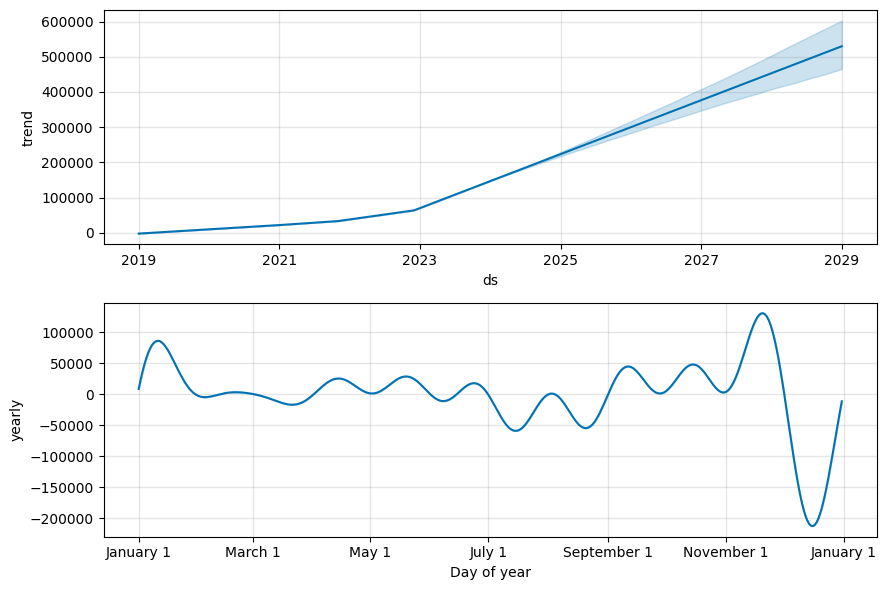

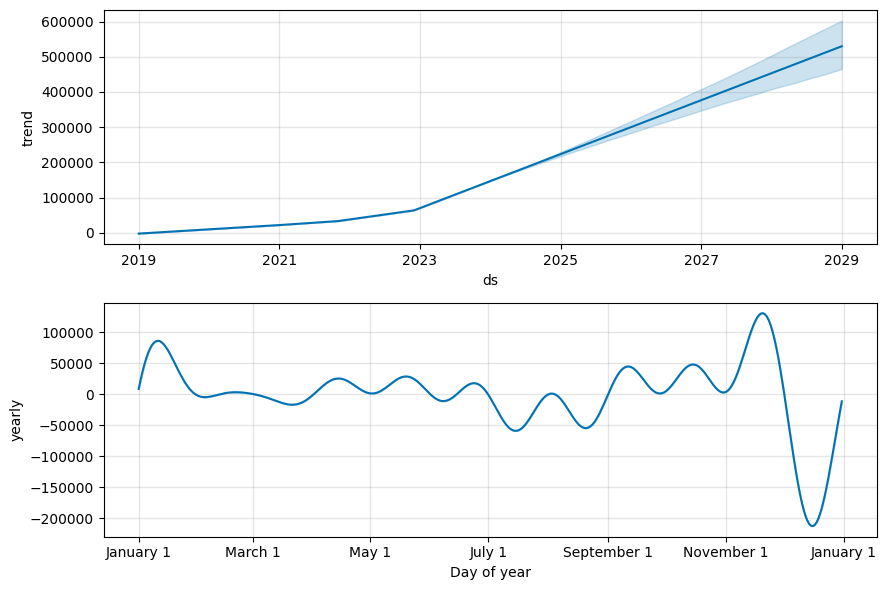

In [1062]:
# Prepare data for Prophet forecasting
seasonality_data = sales_data.copy()
seasonality_data.columns = ['ds', 'y']  # Rename columns for Prophet compatibility

# Fit Prophet model with yearly seasonality
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(seasonality_data)

# Generate future predictions
future = prophet_model.make_future_dataframe(periods=60, freq='MS')
forecast = prophet_model.predict(future)

# Visualize the seasonality and trend components
prophet_model.plot_components(forecast)

In [1063]:
# Extract the yearly seasonality from the forecast
yearly_seasonality = forecast[['ds', 'yearly']]

# Yearly sales seasonality
fig11 = go.Figure()

fig11.add_trace(go.Scatter(
    x=yearly_seasonality['ds'], 
    y=yearly_seasonality['yearly'], 
    mode='lines', 
    name='Yearly Seasonality',
    line_shape='spline',  
    fill='tozeroy',  
    fillcolor='#B7E0B1', 
    opacity=0.1 
))

fig11.update_layout(
    title=' Yearly sales seasonality',
    xaxis_title='Date',
    yaxis_title='Seasonal Effect',
    legend=dict(orientation='h', yanchor='bottom', y=-0.3, xanchor='center', x=0.5),
    height=600,
    plot_bgcolor='white'
)

fig11.update_traces(
    hovertemplate='<b>Date:</b> %{x}<br> <b>Revenue:</b> $%{y:.2f}<extra></extra>'
)

fig11.show()

### Weekday vs. Weekend sales pattern

Compared the performance of sales on `weekdays` vs `weekends` and provide actionable insights for improving weekend sales.<br>
<br>

**Insight:**

Weekdays consistently outperform weekends in terms of sales, likely due to work-related browsing and purchasing behavior. Marketing efforts could focus on boosting weekend sales to balance the difference or simply improve it.

In [1064]:
# Classify dates as weekday or weekend
product_performance['day_of_week'] = product_performance['created_at_x'].dt.dayofweek
product_performance['weekday_weekend'] = product_performance['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Group sales by weekday vs weekend
weekday_vs_weekend_sales = product_performance.groupby('weekday_weekend').agg({'revenue': 'sum'}).reset_index()

# Plot weekday vs weekend sales

fig12 = px.bar(
    weekday_vs_weekend_sales, 
    x='weekday_weekend', 
    y='revenue', 
    title='Weekday vs Weekend Sales',
    labels={'revenue': 'Revenue ($)', 'weekday_weekend': 'Day Type'},
    color='weekday_weekend',
    color_discrete_sequence=['#607D77', '#B7E0B1']
)


fig12.update_layout(
    xaxis_title='Day Type',
    yaxis_title='Revenue ($)',
    showlegend=False, 
    height=600
)

fig12.update_traces(
    hovertemplate='<b>Day Type:</b> %{x}<br><b>Revenue:</b> $%{y:.2f}<extra></extra>'
)

fig12.show()


### Country-Specific Weekday vs Weekend Sales

I wanted to examine the variation in sales performance across different countries between weekdays and weekends..<br>
<br>

**Insight:**

- Countries like the **U.S**. and **China** contribute significantly more during weekdays, while some countries show a relatively balanced performance between weekdays and weekends. 
- Region-specific marketing strategies can be designed based on these behaviors.

In [1065]:
# Create a new column for 'weekday' or 'weekend'
product_performance['day_of_week'] = product_performance['created_at_x'].dt.dayofweek
product_performance['weekday_weekend'] = product_performance['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Group by country and weekday/weekend and sum the revenue
country_sales_by_day_type = product_performance.groupby(['country', 'weekday_weekend']).agg({
    'revenue': 'sum'
}).reset_index()

# Plot country-specific weekday vs weekend sales
fig13 = px.bar(
    country_sales_by_day_type, 
    x='country', 
    y='revenue', 
    color='weekday_weekend',
    title='Country-specific weekday vs weekend sales',
    labels={'revenue': 'Revenue ($)', 'country': 'Country', 'weekday_weekend': 'Day Type'},
    barmode='group', 
    color_discrete_sequence=['#607D77', '#B7E0B1'],  
    text='revenue' 
)


fig13.update_layout(
    xaxis_title='Country',
    yaxis_title='Revenue ($)',
    yaxis=dict(range=[0, country_sales_by_day_type['revenue'].max() * 1.2]),
    bargap=0.15,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.3,
        xanchor='center',
        x=0.5
    ),
    height=700
)

fig13.update_traces(
    texttemplate='%{text:.2s}', 
    textposition='outside',  
    marker_line_width=1.5,  
    hovertemplate='<b>Country:</b> %{x}<br><b>Revenue:</b> $%{y:.2f}<extra></extra>',  
    marker_line_color='black'  # Bar border color for better contrast
)

fig13.show()
